In [297]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from utils import get_data, get_probabilities, estimate_q_Z_given_A, get_probabilities_one_hot
from sklearn.decomposition import NMF  # Placeholder for volmin factorization
from volmin_nmf import *
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from scipy.optimize import nnls
from sklearn.metrics import roc_auc_score
from sklearn.kernel_ridge import KernelRidge
from sklearn import random_projection as r_proj
from collections import defaultdict


In [298]:
# ======================================================================================================================
#                                                     Flags
# ======================================================================================================================
'''
debug: Flag to print debug information such as the shape of the data, examples of data, confusion matrices etc.
summary: Flag to print summary information such as accuracy of models and the final q(Y|a)
run_covar: Flag to run the COVAR model
'''
debug = False
summary = False
run_covar = False
run_label_shift = False
run_source_baseline = True
alternate = False
use_R_code = True
R_code_matrix = np.array([
    [0.50142937, 0.00000000],
    [0.00000000, 0.50360114],
    [0.09614304, 0.40202105],
    [0.40242759, 0.09437782]
])
R_code_H = np.array([
    [0.09527976, 1.7592325],
    [1.70604144, 0.4028682]
])
# Calculate the row sums
R_code_row_sums = R_code_matrix.sum(axis=1, keepdims=True)
R_code_normalised = R_code_matrix / R_code_row_sums
# Print the row sums and normalized matrix
print("Row Sums:\n", R_code_row_sums)
print("Normalized Matrix:\n", R_code_normalised)
R_code_p_W_given_epsilon = R_code_normalised[2:, :]

# ======================================================================================================================
#                                             Experiment Parameters
# ======================================================================================================================

p_target_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Example values, you can define your own range
specific_a_index_values = [0, 1, 2]
p_source = 0.2

# ======================================================================================================================
#                                           Data Generation Parameters
# ======================================================================================================================
'''
These parameters are used to generate the data.
p_source: Probability of a sample being from the source domain
p_target: Probability of a sample being from the target domain
total: Total number of samples
factorisation_atol: Absolute tolerance for the factorisation
specific_a_index: Index of the specific A value to be used
num_classes_Y: Number of classes for Y
num_classes_W: Number of classes for W
num_features_Z: Number of features for Z
num_features_A: Number of features for A
'''

total = 10000
factorisation_atol = 1e-1
#specific_a_index = 0  # First value of A
num_classes_Y = 2 
num_classes_W = 2
num_features_Z = 2
num_features_A = 3
num_epsilon = 2 # min(W_source.shape[1], Z_source.shape[1]) # Remember we need this to be less than the min of |W| and |Z|. Consider changing this as a hyperparameter

# ======================================================================================================================
#                                                NMF Parameters
# ======================================================================================================================
'''
Parameters for the NMF factorisation
nmf_method: Method for the NMF factorisation (currently uses https://github.com/bm424/mvcnmf/tree/master and activated by "volmin_2")
w_vol: Volume regularisation parameter
delta: Delta parameter for the NMF factorisation
n_iter: Number of iterations for the NMF factorisation
err_cut: Error cut-off for the NMF factorisation
'''
nmf_method = "volmin_2" 
w_vol = 0.01#0.1
delta = 1e-8
n_iter = 200000
err_cut = 1e-10

# ======================================================================================================================
#                                           Random Seed Initialisation
# ======================================================================================================================
np.random.seed(0)
torch.manual_seed(0)

Row Sums:
 [[0.50142937]
 [0.50360114]
 [0.49816409]
 [0.49680541]]
Normalized Matrix:
 [[1.         0.        ]
 [0.         1.        ]
 [0.19299472 0.80700528]
 [0.81003061 0.18996939]]


In [299]:
# ======================================================================================================================
#                                          Matrices for Data Generation
# ======================================================================================================================
'''
These matrices are used to generate the data.
theta_w_epsilon: Matrix for W given Epsilon
theta_z_epsilon: Matrix for Z given Epsilon
theta_a_z_epsilon: Matrix for A given Z and Epsilon
theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon

The dimensions of the variables are as follows:
W: 2D
Z: 2D
A: 3D
Y: 2D
Epsilon: 2D
'''

# theta_w_epsilon = torch.tensor([
#     [-2, 2],
#     [2, -2]
# ])

# theta_z_epsilon = torch.tensor([
#     [-2, 2],
#     [2, -2]
# ])

theta_w_epsilon = torch.tensor([
    # [5],
    # [-5]
    [-2],
    [2]
])

theta_z_epsilon = torch.tensor([
    # [5],
    # [-5]
    [-2],
    [2]
])

theta_a_z_epsilon = torch.tensor([
    [2.0, -2.0],  
    [-2.0, 2.0],
    [2.0, -2.0]
]) 

theta_y_a_w_epsilon = torch.tensor([
    #[10, 3, -5, -3, 3]
    #[15, 10, -2, -3, 3]
    #[5, 5, -2, -3, 3]
    # [5, 5, -3, -3, 3]
    [1, 1, -5, -4, 6]
]) 

In [300]:
# ======================================================================================================================
#                                          Data Generation Functions
# ======================================================================================================================

def get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p):
    '''
    Generates a tuple of data points for the given parameters.

    Parameters:
    theta_w_epsilon: Matrix for W given Epsilon
    theta_z_epsilon: Matrix for Z given Epsilon
    theta_a_z_epsilon: Matrix for A given Z and Epsilon
    theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon
    p: Probability of a sample being from the target domain

    Returns:
    epsilon: Epsilon value via Bernoulli distribution
    z: Z value via Bernoulli distribution and sigmoid function
    w: W value via Bernoulli distribution and sigmoid function
    a: A value via theta_a_z_epsilon @ z or -theta_a_z_epsilon @ z depending on epsilon. One-hot encoded
    y: Y value via Bernoulli distribution and sigmoid function of theta_y_a_w_epsilon @ [w, a] or -theta_y_a_w_epsilon @ [w, a] depending on epsilon
    '''

    epsilon = torch.bernoulli(torch.tensor([p])).long() # (1,)
    epsilon_one_hot = torch.nn.functional.one_hot(epsilon.clone().detach(), num_classes=2).squeeze() # (1,2)

    # z = torch.bernoulli(torch.sigmoid(epsilon_one_hot @ theta_z_epsilon)).float().squeeze()
    # w = torch.bernoulli(torch.sigmoid(epsilon_one_hot @ theta_w_epsilon)).float().squeeze() 

    ### EXPT START ###
    # Calculate a single probability for z and w using sigmoid activation
    z_prob = torch.sigmoid(epsilon_one_hot @ theta_z_epsilon).squeeze()  # Now a single probability
    w_prob = torch.sigmoid(epsilon_one_hot @ theta_w_epsilon).squeeze()  # Now a single probability

    # Sample z and w using Bernoulli distribution
    z_sampled = torch.bernoulli(z_prob).long()  # Convert to long for one-hot encoding
    w_sampled = torch.bernoulli(w_prob).long()

    # Convert sampled z and w to one-hot vectors
    z = torch.nn.functional.one_hot(z_sampled, num_classes=2).float()
    w = torch.nn.functional.one_hot(w_sampled, num_classes=2).float()
    ### EXPT END ###


    a_logits = epsilon * theta_a_z_epsilon.float() @ z.float() + (epsilon-1) * theta_a_z_epsilon.float() @ z.float() #epsilon is 0 or 1, theta_a_z_epsilon is 3x2, z is [2]. So result is 3x1
    a_prob = torch.softmax(a_logits, dim=0)  # Apply softmax to convert logits to probabilities
    if debug:
        print(a_prob)   
    a_category = torch.multinomial(a_prob, 1).squeeze()  # Sample from the categorical distribution
    a = torch.nn.functional.one_hot(a_category, num_classes=3).float()  # Convert to one-hot encoding
    if debug:
        print(a)
    # a = torch.bernoulli(torch.sigmoid(a_logits)).float().squeeze() # a is size 3

    # concatenate w and a
    # then similar but use different matrix and w,a instead of z
    wa = torch.cat((w, a), dim=0) # [5]

    y_logits = epsilon * theta_y_a_w_epsilon @ wa.long() + (epsilon-1) * theta_y_a_w_epsilon @ wa.long() # y is a function of a, w and epsilon from the graph
    #print(torch.sigmoid(y_logits))
    y = torch.bernoulli(torch.sigmoid(y_logits).squeeze()).float()

    return epsilon,z,w,a,y


def get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p, total):
    '''
    Generates a dataset of data points for the given parameters, using the get_tuple_new function.

    Parameters:
    theta_w_epsilon: Matrix for W given Epsilon
    theta_z_epsilon: Matrix for Z given Epsilon
    theta_a_z_epsilon: Matrix for A given Z and Epsilon
    theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon
    p: Probability of a sample being from the target domain
    total: Total number of samples

    Returns:
    U: List of Epsilon values
    Z: List of Z values
    W: List of W values
    X: List of A values
    Y: List of Y values
    '''

    U,Z,W,X,Y = [],[],[],[],[]
    for _ in range(total):
        u,z,w,x,y = get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p)
        U.append(u)
        Z.append(z)
        W.append(w)
        X.append(x)
        Y.append(y)

    return U,Z,W,X,Y


def get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target, p_source, total):
    '''
    Returns the source and target datasets for the given parameters.

    Parameters:
    theta_w_epsilon: Matrix for W given Epsilon
    theta_z_epsilon: Matrix for Z given Epsilon
    theta_a_z_epsilon: Matrix for A given Z and Epsilon
    theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon
    p_target: Probability of a sample being from the target domain
    total: Total number of samples

    Returns:
    (Z_source, U_source, W_source, X_source, Y_source): Source dataset
    (Z_target, U_target, W_target, X_target, Y_target): Target dataset
    '''
    
    # Source distribution data
    #print(p_source)
    U_source, Z_source, W_source, X_source, Y_source = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, total)
    
    # Target distribution data
    #print(p_target)
    U_target, Z_target, W_target, X_target, Y_target = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target, total)
    
    return (Z_source, U_source, W_source, X_source, Y_source), \
           (Z_target, U_target, W_target, X_target, Y_target)

def tensor_to_binary(tensor):
    return 1 if tensor[0] == 1 else 0

def tensors_to_numpy(tensor_list):
    return np.array([t.numpy() for t in tensor_list])

def get_probabilities(model, Z_source, A_source):
    '''
    Function to get the probabilities of Y given all possible Z and A and put them in a 3D array.
    '''

    # Convert lists of tensors to numpy arrays
    Z = np.array([z.numpy() for z in Z_source])
    A = np.array([a.numpy() for a in A_source])
    
    num_Z = Z.shape[1]
    num_A = A.shape[1]

    # Generate all possible one-hot vectors for Z and A
    possible_Z = np.eye(num_Z)
    possible_A = np.eye(num_A)
    
    probabilities = []
    
    for z in possible_Z:
        for a in possible_A:
            ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
            # Flatten ZA for the MLPClassifier
            ZA_flat = ZA.flatten().reshape(1, -1)
            prob = model.predict_proba(ZA_flat)[0]
            probabilities.append(prob)
    
    probabilities = np.array(probabilities).reshape((num_Z, num_A, 2))
    
    return probabilities

In [301]:
###################################################### BASELINES #######################################################

# ======================================================================================================================
#                                                       COVAR
# ======================================================================================================================

'''
COVAR: Implementation of covariate shift adaptation method.
'''

# Author: Nicole Chiou <nicchiou@stanford.edu>, Katherine Tsai <kt14@illinois.edu>
# MIT License


def convert_data_y2d(source, target):
    source_y = np.zeros_like(source["Y"])
    target_y = np.ones_like(target["Y"])

    return {
        "X": np.concatenate([source["X"], target["X"]], axis=0),
        "Y": np.concatenate([source_y, target_y], axis=0).ravel(),
    }


class COVAR:
    """Covariate shift adaptation."""

    def __init__(self, alpha=1.0, kernel="rbf", proj_dim=16):
        self.source_covar_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.target_covar_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.proj_dim = proj_dim

    def fit(self, source_train, target_train):
        domain_d = convert_data_y2d(source_train, target_train)
        proj = r_proj.GaussianRandomProjection(
            n_components=self.proj_dim, random_state=0
        ).fit(domain_d["X"])
        d_x = SklearnLogisticRegression(random_state=0)
        d_x.fit(proj.transform(domain_d["X"]), domain_d["Y"])

        # Compute sample weights
        q_x_train = d_x.predict_proba(proj.transform(source_train["X"]))[:, 1]
        source_sample_weight_train = q_x_train / (1.0 - q_x_train + 1e-3)

        # Fit source model
        self.source_covar_model.fit(
            source_train["X"],
            source_train["Y"],
            sample_weight=source_sample_weight_train,
        )

        # Compute sample weights
        q_x_train = d_x.predict_proba(proj.transform(target_train["X"]))[:, 0]
        target_sample_weight_train = q_x_train / (1.0 - q_x_train + 1e-3)

        # Fit target model
        self.target_covar_model.fit(
            target_train["X"],
            target_train["Y"],
            sample_weight=target_sample_weight_train,
        )

    def predict(self, test_data):
        return self.source_covar_model.predict(test_data["X"])

    def predict_target(self, test_data):
        return self.target_covar_model.predict(test_data["X"])

# ======================================================================================================================
#                                                    Label Shift
# ======================================================================================================================

"""Implementation of label shift adaptation method."""

# Author: Nicole Chiou <nicchiou@stanford.edu>, Katherine Tsai <kt14@illinois.edu>
# MIT License


import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize
import cvxpy as cp
import scipy

class ConLABEL:
    """
    Continuous label shift adaptation.

    Zhang, K., Schölkopf, B., Muandet, K., & Wang, Z. (2013, May).
    Domain adaptation under target and conditional shift.
    In International conference on machine learning (pp. 819-827). PMLR.
    """

    def __init__(self, lam, bp, alpha, kernel, kernel2):
        self.lam = lam
        self.bp = bp
        self.kernel = kernel
        self.label_model = KernelRidge(alpha=alpha, kernel=kernel2)

    def fit(self, source_data, target_x):

        # Learn the weight
        K_Y = self.kernel(source_data["Y"], source_data["Y"])

        K_X = self.kernel(source_data["X"], source_data["X"])
        m1 = K_X.shape[0]

        inv_KY = scipy.linalg.solve(K_Y + self.lam * np.eye(m1), np.eye(m1))
        inv_KY_KY = np.einsum("ij,jk->ik", inv_KY, K_Y)

        K_X1X2 = self.kernel(source_data["X"], target_x)
        m2 = K_X1X2.shape[1]
        A = inv_KY_KY.T @ K_X @ inv_KY_KY

        B = K_X1X2.T @ inv_KY_KY
        B = (m1 / m2) * B
        B = np.sum(B, axis=0)
        G = np.eye(m1)
        G2 = -np.eye(m1)
        x = cp.Variable(m1)
        h = self.bp * np.ones(m1)
        h2 = np.zeros(m1)
        C = np.ones(m1)
        eps = self.bp * np.sqrt(m1) / 4
        print("start fitting")
        prob = cp.Problem(
            cp.Minimize((1 / 2) * cp.quad_form(x, A) + B.T @ x),
            [G @ x <= h, G2 @ x <= h2, C @ x <= eps + m1, -C @ x <= -m1 + eps],
        )

        prob.solve()
        print("finished")
        print(f"Problem status {prob.status}")
        beta = np.array(x.value)
        idx = np.where(beta < 0)[0]
        beta[idx] = 0
        beta = normalize(beta[:, np.newaxis]).squeeze()
        self.label_model.fit(
            source_data["X"],
            source_data["Y"],
            sample_weight=beta,
        )

    def predict(self, test_data):
        return self.label_model.predict(test_data)


class LABEL:
    """
    implementation of label shift adaptation method.
    """

    def __init__(self, alpha, kernel="rbf", kernel2="gaussian", bandwidth=1):
        self.source_kde = KernelDensity(kernel=kernel2, bandwidth=bandwidth)
        self.target_kde = KernelDensity(kernel=kernel2, bandwidth=bandwidth)

        self.source_label_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.target_label_model = KernelRidge(alpha=alpha, kernel=kernel)

    def fit(self, source_train, source_val, target_train):
        self.source_kde.fit(source_val["Y"])
        self.target_kde.fit(target_train["Y"])

        # Compute sample weights q(Y)/p(Y)
        log_q_y = self.target_kde.score_samples(source_train["Y"])
        log_p_y = self.source_kde.score_samples(source_train["Y"])

        source_sample_weight_train = np.exp(log_q_y - log_p_y)

        # Fit source model
        self.source_label_model.fit(
            source_train["X"],
            source_train["Y"],
            sample_weight=source_sample_weight_train,
        )

        # Compute sample weights p(Y)/q(Y)
        target_sample_weight_train = np.exp(log_p_y - log_q_y)

        # Fit target model
        self.target_label_model.fit(
            target_train["X"],
            target_train["Y"],
            sample_weight=target_sample_weight_train,
        )

    def predict(self, test_data):
        return self.source_label_model.predict(test_data["X"])

    def predict_target(self, test_data):
        return self.target_label_model.predict(test_data["X"])

In [302]:
def run_algorithm(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total, specific_a_index, num_classes_Y, num_classes_W, num_features_Z, num_features_A, num_epsilon, nmf_method, w_vol, delta, n_iter, err_cut, summary = True, alternate = False):
    '''Runs the full algorithm'''

    # Generate the source and target datasets
    source_data, target_data = get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target, p_source, total)
    Z_source, epsilon_source, W_source, A_source, Y_source = source_data
    Z_target, epsilon_target, W_target, A_target, Y_target = target_data

    # Split source data into training, validation, and test sets
    A_train_val_source, A_test_source, Z_train_val_source, Z_test_source, W_train_val_source, W_test_source, Y_train_val_source, Y_test_source, epsilon_train_val_source, epsilon_test_source = train_test_split(
    A_source, Z_source, W_source, Y_source, epsilon_source, test_size=0.2, random_state=42)
    A_train_source, A_val_source, Z_train_source, Z_val_source, W_train_source, W_val_source, Y_train_source, Y_val_source, epsilon_train_source, epsilon_val_source = train_test_split(
    A_train_val_source, Z_train_val_source, W_train_val_source, Y_train_val_source, epsilon_train_val_source, test_size=0.25, random_state=42)

    # Split target data into training, validation, and test sets
    A_train_val_target, A_test_target, Z_train_val_target, Z_test_target, W_train_val_target, W_test_target, Y_train_val_target, Y_test_target, epsilon_train_val_target, epsilon_test_target = train_test_split(
    A_target, Z_target, W_target, Y_target, epsilon_target, test_size=0.2, random_state=42)
    A_train_target, A_val_target, Z_train_target, Z_val_target, W_train_target, W_val_target, Y_train_target, Y_val_target, epsilon_train_target, epsilon_val_target = train_test_split(
    A_train_val_target, Z_train_val_target, W_train_val_target, Y_train_val_target, epsilon_train_val_target, test_size=0.25, random_state=42)

    # Step 1
    ZA_source = np.hstack((Z_train_source, A_train_source)) 
    model_Y = SklearnLogisticRegression(max_iter=1000)
    model_Y.fit(ZA_source, Y_train_source)
    Y_train_pred = model_Y.predict(ZA_source)
    Y_train_true = Y_train_source
    accuracy_Y_train = np.mean(Y_train_pred == Y_train_source)
    # test set
    ZA_source_test = np.hstack((Z_test_source, A_test_source))
    Y_test_pred = model_Y.predict(ZA_source_test)
    Y_test_true = Y_test_source
    accuracy_Y_test = np.mean(Y_test_pred == Y_test_true)
    # W 
    # Convert the list of tensors to a list of binary labels
    binary_labels = [tensor_to_binary(t) for t in W_train_source]

    # Convert to numpy array (optional)
    binary_labels_array = np.array(binary_labels)

    model_W= SklearnLogisticRegression(max_iter=1000)
    model_W.fit(ZA_source, binary_labels_array)
    W_train_pred = model_W.predict(ZA_source)
    W_train_true = W_source
    accuracy_W_train = np.mean(W_train_pred == binary_labels_array)
    # Test set
    W_test_pred = model_W.predict(ZA_source_test)
    W_test_true = np.array([tensor_to_binary(t) for t in W_test_source])
    accuracy_W_test = np.mean(W_test_pred == W_test_true)

    p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)
    p_W_given_ZA = get_probabilities(model_W, Z_source, A_source)


    #############################
    if alternate:
        Z_source_np = np.array([z.numpy() for z in Z_train_source])
        A_source_np = np.array([a.numpy() for a in A_train_source])
        Y_source_np = np.array([y.numpy() for y in Y_train_source])
        W_source_np = np.array([w.numpy() for w in W_train_source])
        # Extract indices from one-hot encoding
        Z_indices = np.argmax(Z_source_np, axis=1)
        A_indices = np.argmax(A_source_np, axis=1)
        W_indices = np.argmax(W_source_np, axis=1)
        # Initialize count dictionaries
        count_Y_given_ZA = defaultdict(int)
        count_W_given_ZA = defaultdict(int)
        count_ZA = defaultdict(int)
        # Count occurrences
        for i in range(len(Y_source_np)):
            z = Z_indices[i]  # Extract index from one-hot encoding
            a = A_indices[i]
            y = int(Y_source_np[i])  # Convert to integer index for Y
            w = W_indices[i]
            # Count (Y, Z, A) and (W, Z, A) occurrences
            count_Y_given_ZA[(z, a, y)] += 1
            count_W_given_ZA[(z, a, w)] += 1
            count_ZA[(z, a)] += 1
        p_Y_given_ZA_array = np.zeros((num_features_Z, num_features_A, num_classes_Y))
        p_W_given_ZA_array = np.zeros((num_features_Z, num_features_A, num_classes_W))
        for (z, a, y), count in count_Y_given_ZA.items():
            if count_ZA[(z, a)] > 0:
                p_Y_given_ZA_array[z, a, y] = count / count_ZA[(z, a)]
        for (z, a, w), count in count_W_given_ZA.items():
            if count_ZA[(z, a)] > 0:
                p_W_given_ZA_array[z, a, w] = count / count_ZA[(z, a)]
        p_Y_given_ZA = p_Y_given_ZA_array
        p_W_given_ZA = p_W_given_ZA_array
    ##########################





    p_Y_given_ZA_matrix = p_Y_given_ZA[:, specific_a_index, :]
    p_W_given_ZA_matrix = p_W_given_ZA[:, specific_a_index, :]
    if debug:
        print("Step 1 done")

    # Step 2
    stacked_matrix = np.vstack((p_Y_given_ZA_matrix, p_W_given_ZA_matrix)) # this should be a |Y| x |Z| matrix stacked on top of a |W| x |Z| matrix (for specific a)
    W, H = mvc_nmf(stacked_matrix.T, num_epsilon, w_vol, n_iter, err_cut) # Transpose the matrix to match the input format of the function

    p_Y_given_epsilon = W[:num_classes_Y, :] # |Y| x |\Epsilon| matrix for specific a, the first num_classes_Y rows #CHECK NUM_CLASSES_Y IS THE ONE
    p_W_given_epsilon = W[num_classes_Y:, :] # |W| x |\Epsilon| matrix for specific a, the rest of the rows #CHECK NUM_CLASSES_Y IS THE ONE
    p_epsilon_given_ZA = H # |\Epsilon| x |Z| matrix for specific a
    reconstructed_stacked_matrix = np.dot(W, H)
    if use_R_code:
        p_Y_given_epsilon = R_code_normalised[:num_classes_Y, :]
        p_W_given_epsilon = R_code_normalised[num_classes_Y:, :]
    if debug:
        print("Step 2 done")

    # Step 3
    ZA_train_target = np.hstack((Z_train_target, A_train_target))
    # Convert the list of tensors to a list of binary labels
    binary_labels_target = [tensor_to_binary(t) for t in W_train_target]
    # Convert to numpy array (optional)
    binary_labels_target_array = np.array(binary_labels_target)
    model_q_W = SklearnLogisticRegression(max_iter=1000)
    model_q_W.fit(ZA_train_target, binary_labels_target_array)
    W_train_pred_target = model_q_W.predict(ZA_train_target)
    W_train_true_target = W_train_target
    accuracy_W_train_target = np.mean(W_train_pred_target == binary_labels_target_array)
    q_W_given_ZA = get_probabilities(model_q_W, Z_target, A_target)
    if debug:
        print("Step 3 done")

    # Step 4
    q_W_given_ZA_specific_a = q_W_given_ZA[:, specific_a_index, :]
    q_epsilon_given_Z_and_A, _, _, _ = np.linalg.lstsq(p_W_given_epsilon, q_W_given_ZA_specific_a, rcond=None) 
    q_epsilon_given_Z_and_A #note I'm getting a negative value here
    if debug:
        print("Step 4 done")

    # Step 5
    # Convert the list of tensors to a list of binary labels
    binary_labels_target_Z = [tensor_to_binary(t) for t in Z_train_target]
    # Convert to numpy array (optional)
    binary_labels_target_array_Z = np.array(binary_labels_target_Z)
    model_q_Z = SklearnLogisticRegression(max_iter=1000)#, class_weight = class_weights)
    model_q_Z.fit(A_train_target, binary_labels_target_array_Z)
    Z_train_pred_target = model_q_Z.predict(A_train_target)
    Z_train_true_target = Z_train_target
    accuracy_Z_train_target = np.mean(Z_train_pred_target == binary_labels_target_array_Z)
    if debug:
        print("Step 5 done")

    # Step 6
    one_hot_specific_a = np.eye(len(A_source[0]))[specific_a_index].reshape(1, -1)
    q_Z_given_A = model_q_Z.predict_proba(one_hot_specific_a)
    q_Y_given_A = p_Y_given_epsilon@(q_epsilon_given_Z_and_A@q_Z_given_A.T)
    q_Y_given_a_normalised = q_Y_given_A / np.sum(q_Y_given_A)
    if debug:
        print("Step 6 done")

    if summary:
        print("Summary:")
        if not alternate:
            print(f"Accuracy of model_Y on training set: {accuracy_Y_train * 100:.2f}%")
            print(f"Accuracy of model_Y on test set: {accuracy_Y_test * 100:.2f}%")
        print(f"Accuracy of model_W on training set: {accuracy_W_train * 100:.2f}%")
        print(f"Accuracy of model_W on test set: {accuracy_W_test * 100:.2f}%")
        print(f"Accuracy of model_W on training set (target): {accuracy_W_train_target * 100:.2f}%")
        print(f"Accuracy of model_W on test set (target): {accuracy_W_test * 100:.2f}%")
        print(f"Accuracy of model on training set (target): {accuracy_Z_train_target * 100:.2f}%")

    return q_Y_given_a_normalised, A_test_target, Y_test_target, Z_test_target, Z_train_source, Y_train_source, Z_train_target, Y_train_target, Z_val_source, Y_val_source, A_train_source

In [303]:
# Run algorithm for different values of A and p_target

In [304]:
def extract_probabilities(A_test_target, q_Y_given_a_all):
    num_instances = len(A_test_target)
    prob_Y_1 = np.zeros(num_instances)
    
    for i in range(num_instances):
        # Convert the tensor to a numpy array
        a_one_hot = A_test_target[i].numpy()
        
        # Find the index of the one-hot encoded a
        a_index = np.argmax(a_one_hot)
        
        # Assign the probability for Y=1 from q_Y_given_a_all
        prob_Y_1[i] = q_Y_given_a_all[a_index, 1]  # Probability for Y=1

    return prob_Y_1

# Function to calculate AUROC
def calculate_auroc(Y_test_target, prob_Y_1):
    return roc_auc_score(Y_test_target, prob_Y_1)

# Initialize storage for results
results = []

if run_covar:
    results_covar = []

if run_label_shift:
    results_label_shift = []

if run_source_baseline:
    results_source_baseline = []

# This is for tracking test accuracy
accuracy_results = [] 
accuracy_results_covar = []
accuracy_results_label_shift = []
accuracy_results_source_baseline = []

for p_target in p_target_values:
    print("p_source:", p_source)
    p_source = p_source
    
    # Initialize array to store q(Y|a) for all specific a values
    q_Y_given_a_all = np.zeros((len(specific_a_index_values), num_classes_Y))
    
    # Collect probabilities for each specific a value
    for specific_a_index in specific_a_index_values:
        # Run your algorithm to get the probabilities for each specific a
        q_Y_given_a_normalised, A_test_target, Y_test_target, Z_test_target, Z_train_source, Y_train_source, Z_train_target, Y_train_target, Z_val_source, Y_val_source, A_train_source = run_algorithm(
            theta_w_epsilon, theta_z_epsilon, theta_a_z_epsilon, theta_y_a_w_epsilon,
            p_source, p_target, total, specific_a_index, num_classes_Y, num_classes_W,
            num_features_Z, num_features_A, num_epsilon, nmf_method, w_vol, delta,
            n_iter, err_cut, summary=summary, alternate=alternate
        )

        

        if run_covar:
            Z_train_source_np = tensors_to_numpy(Z_train_source)
            Y_train_source_np = tensors_to_numpy(Y_train_source).flatten()  # Flatten for 1D labels

            Z_train_target_np = tensors_to_numpy(Z_train_target)
            Y_train_target_np = tensors_to_numpy(Y_train_target).flatten()  # Flatten for 1D labels

            Z_val_source_np = tensors_to_numpy(Z_val_source)
            Y_val_source_np = tensors_to_numpy(Y_val_source).flatten()  # Validation labels

            Z_test_target_np = tensors_to_numpy(Z_test_target)

            # Prepare the source and target training dictionaries
            source_train = {
                "X": Z_train_source_np,  # Features from source domain
                "Y": Y_train_source_np   # Labels from source domain
            }

            source_val = {
                "Y": Y_val_source_np
            }

            target_train = {
                "X": Z_train_target_np,  # Features from target domain
                "Y": Y_train_target_np   # Labels from target domain
            }

            # Prepare the test data dictionary
            test_data = {
                "X": Z_test_target_np    # Test features
            }
            # Initialize the COVAR model
            covar_model = COVAR(alpha=1.0, kernel="rbf", proj_dim=16)

            # Fit the model on the source and target training data once for the setup
            covar_model.fit(source_train, target_train)

        if run_label_shift:
            Z_train_source_np = tensors_to_numpy(Z_train_source)
            Y_train_source_np = tensors_to_numpy(Y_train_source).flatten()  # Flatten for 1D labels

            Z_train_target_np = tensors_to_numpy(Z_train_target)
            Y_train_target_np = tensors_to_numpy(Y_train_target).flatten()  # Flatten for 1D labels

            Z_val_source_np = tensors_to_numpy(Z_val_source)
            Y_val_source_np = tensors_to_numpy(Y_val_source).flatten()  # Validation labels

            Z_test_target_np = tensors_to_numpy(Z_test_target)

            # Prepare the source and target training dictionaries
            source_train = {
                "X": Z_train_source_np,  # Features from source domain
                "Y": Y_train_source_np   # Labels from source domain
            }

            source_val = {
                "Y": Y_val_source_np
            }

            target_train = {
                "X": Z_train_target_np,  # Features from target domain
                "Y": Y_train_target_np   # Labels from target domain
            }

            # Prepare the test data dictionary
            test_data = {
                "X": Z_test_target_np    # Test features
            }
            # Reshape the labels to be 2D arrays for KDE
            source_val["Y"] = source_val["Y"].reshape(-1, 1)
            target_train["Y"] = target_train["Y"].reshape(-1, 1)
            source_train["Y"] = source_train["Y"].reshape(-1, 1)
            # Initialize the LABEL model
            label_model = LABEL(alpha=1.0, kernel="rbf", kernel2="gaussian", bandwidth=1)

            # Fit the model on the source and target training data once for the setup
            label_model.fit(source_train, source_val, target_train)
        
        # Ensure the shape matches, assuming q_Y_given_a_normalised is (2, 1)
        q_Y_given_a_normalised = q_Y_given_a_normalised.flatten()
        
        # Store the probabilities for the current specific a
        q_Y_given_a_all[specific_a_index] = q_Y_given_a_normalised

        if run_source_baseline:
            # Convert source and target domain data from lists of tensors to NumPy arrays
            A_train_source_np = tensors_to_numpy(A_train_source)
            Y_train_source_np = tensors_to_numpy(Y_train_source).flatten()  # Flatten for 1D labels

            A_test_target_np = tensors_to_numpy(A_test_target)
            Y_test_target_np = tensors_to_numpy(Y_test_target).flatten()  # Flatten for 1D labels
            source_baseline_model = LogisticRegression(max_iter=1000)
            source_baseline_model.fit(A_train_source_np, Y_train_source_np)

    
    # Assign probabilities using all q(Y|a) outputs
    prob_Y_1 = extract_probabilities(A_test_target, q_Y_given_a_all)
    if debug:
        print(prob_Y_1[:20])
        print(Y_test_target[:20])
        print("prob_Y_1", prob_Y_1)
    
    # Calculate AUROC
    auroc = calculate_auroc(Y_test_target, prob_Y_1)
    if run_covar:
        # Get predicted probabilities from the COVAR model
        predicted_probs_covar = covar_model.predict_target(test_data)
        
        # Ensure predicted_probs_covar are clipped within 0-1
        predicted_probs_covar = np.clip(predicted_probs_covar, 0, 1)
        
        # Calculate AUROC for the COVAR model
        auroc_covar = roc_auc_score(Y_test_target, predicted_probs_covar)
        #print(f"COVAR Model AUROC: {auroc_covar:.4f}")

    if run_label_shift:
        # Get predicted probabilities from the COVAR model
        predicted_probs_label_shift = label_model.predict_target(test_data)
        
        # Ensure predicted_probs_covar are clipped within 0-1
        predicted_probs_label_shift = np.clip(predicted_probs_label_shift, 0, 1)
        
        # Calculate AUROC for the COVAR model
        auroc_label_shift = roc_auc_score(Y_test_target, predicted_probs_label_shift)
        #print(f"Label Shift Model AUROC: {auroc_label_shift:.4f}")

    if run_source_baseline:
        predicted_probs_source_baseline = source_baseline_model.predict_proba(A_test_target_np)[:, 1]  # Probability of class 1
        auroc_source_baseline = roc_auc_score(Y_test_target_np, predicted_probs_source_baseline)
    
    # Store the result (p_target, specific_a_index, AUROC)
    results.append((p_target, auroc))
    if run_covar:
        results_covar.append((p_target, auroc_covar))

    if run_label_shift:
        results_label_shift.append((p_target, auroc_label_shift))

    if run_source_baseline:
        results_source_baseline.append((p_target, auroc_source_baseline))
    
    # Print result for each scenario
    print(f"p_target: {p_target:.2f}, AUROC: {auroc:.4f}")

    if run_covar:
        print(f"p_target: {p_target:.2f}, AUROC COVAR: {auroc_covar:.4f}")

    if run_label_shift:
        print(f"p_target: {p_target:.2f}, AUROC Label Shift: {auroc_label_shift:.4f}")

    if run_source_baseline:
        # Calculate AUROC on the target domain
        auroc_source_baseline = roc_auc_score(Y_test_target_np, predicted_probs_source_baseline)
        print(f"Source-trained Baseline Model AUROC on Target Domain: {auroc_source_baseline:.4f}")

    
    # EXPT #
    predictions_your_algorithm = (prob_Y_1 >= 0.5).astype(int)  # Thresholding
    accuracy_your_algorithm = accuracy_score(Y_test_target, predictions_your_algorithm)
    accuracy_results.append((p_target, accuracy_your_algorithm))
    #print("my preds", predictions_your_algorithm[:100])

    if run_covar:
        predicted_probs_covar = covar_model.predict_target(test_data)
        predictions_covar = (predicted_probs_covar >= 0.5).astype(int)
        accuracy_covar = accuracy_score(Y_test_target, predictions_covar)
        accuracy_results_covar.append((p_target, accuracy_covar))
        #print("covar preds", predictions_covar[:100])

    if run_label_shift:
        predicted_probs_label_shift = label_model.predict_target(test_data)
        predictions_label_shift = (predicted_probs_label_shift >= 0.5).astype(int)
        accuracy_label_shift = accuracy_score(Y_test_target, predictions_label_shift)
        accuracy_results_label_shift.append((p_target, accuracy_label_shift))
        #print("label preds", predictions_label_shift[:100])

    if run_source_baseline:
        predicted_probs_source_baseline = source_baseline_model.predict_proba(A_test_target_np)[:, 1]
        predictions_source_baseline = (predicted_probs_source_baseline >= 0.5).astype(int)
        accuracy_source_baseline = accuracy_score(Y_test_target, predictions_source_baseline)
        accuracy_results_source_baseline.append((p_target, accuracy_source_baseline))
        #print(predictions_source_baseline[:100])
    
    #print("actual", Y_test_target[:100])

    print(f"p_target: {p_target:.2f}, Accuracy Your Algorithm: {accuracy_your_algorithm:.4f}")

    if run_covar:
        print(f"p_target: {p_target:.2f}, Accuracy COVAR: {accuracy_covar:.4f}")

    if run_label_shift:
        print(f"p_target: {p_target:.2f}, Accuracy Label Shift: {accuracy_label_shift:.4f}")

    if run_source_baseline:
        print(f"p_target: {p_target:.2f}, Accuracy Source Baseline: {accuracy_source_baseline:.4f}")

    print("============================================================================================================")


p_source: 0.2
p_target: 0.10, AUROC: 0.6403
Source-trained Baseline Model AUROC on Target Domain: 0.6860
p_target: 0.10, Accuracy Your Algorithm: 0.8220
p_target: 0.10, Accuracy Source Baseline: 0.8820
p_source: 0.2
p_target: 0.20, AUROC: 0.6289
Source-trained Baseline Model AUROC on Target Domain: 0.5968
p_target: 0.20, Accuracy Your Algorithm: 0.7610
p_target: 0.20, Accuracy Source Baseline: 0.7850
p_source: 0.2
p_target: 0.30, AUROC: 0.5526
Source-trained Baseline Model AUROC on Target Domain: 0.5661
p_target: 0.30, Accuracy Your Algorithm: 0.6700
p_target: 0.30, Accuracy Source Baseline: 0.7015
p_source: 0.2
p_target: 0.40, AUROC: 0.5233
Source-trained Baseline Model AUROC on Target Domain: 0.5268
p_target: 0.40, Accuracy Your Algorithm: 0.5800
p_target: 0.40, Accuracy Source Baseline: 0.5910
p_source: 0.2
p_target: 0.50, AUROC: 0.4954
Source-trained Baseline Model AUROC on Target Domain: 0.5158
p_target: 0.50, Accuracy Your Algorithm: 0.4995
p_target: 0.50, Accuracy Source Baselin

In [305]:
# Baselines

In [306]:
#results_source_baseline

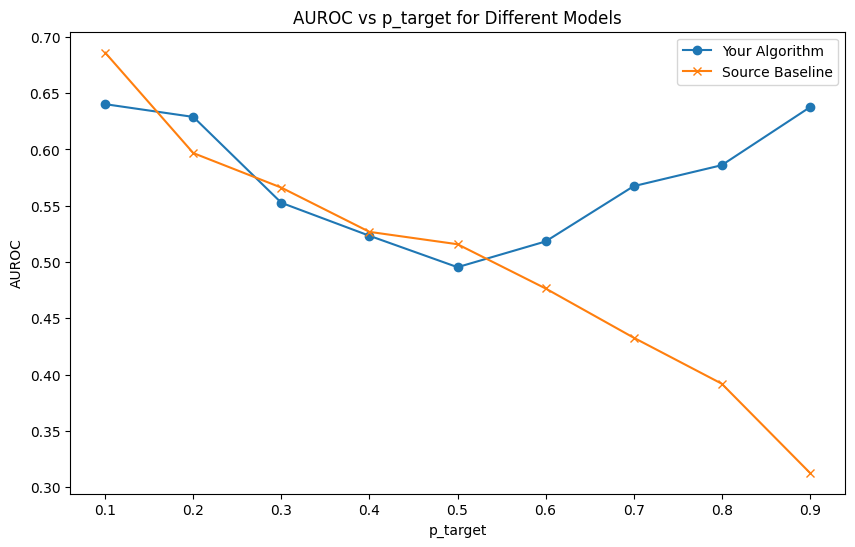

In [307]:

# Extract data for plotting
p_target_values_results = [x[0] for x in results]
auroc_results = [x[1] for x in results]

# Prepare data for COVAR, Label Shift, and Source Baseline if they are being run
if run_covar:
    p_target_values_covar = [x[0] for x in results_covar]
    auroc_covar_results = [x[1] for x in results_covar]

if run_label_shift:
    p_target_values_label_shift = [x[0] for x in results_label_shift]
    auroc_label_shift_results = [x[1] for x in results_label_shift]

if run_source_baseline:
    p_target_values_source_baseline = [x[0] for x in results_source_baseline]
    auroc_source_baseline_results = [x[1] for x in results_source_baseline]

# Plotting
plt.figure(figsize=(10, 6))

# Plot your algorithm's AUROC
plt.plot(p_target_values_results, auroc_results, label="Your Algorithm", marker='o')

# Plot COVAR AUROC if available
if run_covar:
    plt.plot(p_target_values_covar, auroc_covar_results, label="COVAR", marker='s')

# Plot Label Shift AUROC if available
if run_label_shift:
    plt.plot(p_target_values_label_shift, auroc_label_shift_results, label="Label Shift", marker='^')

# Plot Source Baseline AUROC if available
if run_source_baseline:
    plt.plot(p_target_values_source_baseline, auroc_source_baseline_results, label="Source Baseline", marker='x')

# Add labels and title
plt.xlabel("p_target")
plt.ylabel("AUROC")
plt.title("AUROC vs p_target for Different Models")
plt.legend()

# Add grid for better readability
plt.grid(False)

# Show the plot
plt.show()


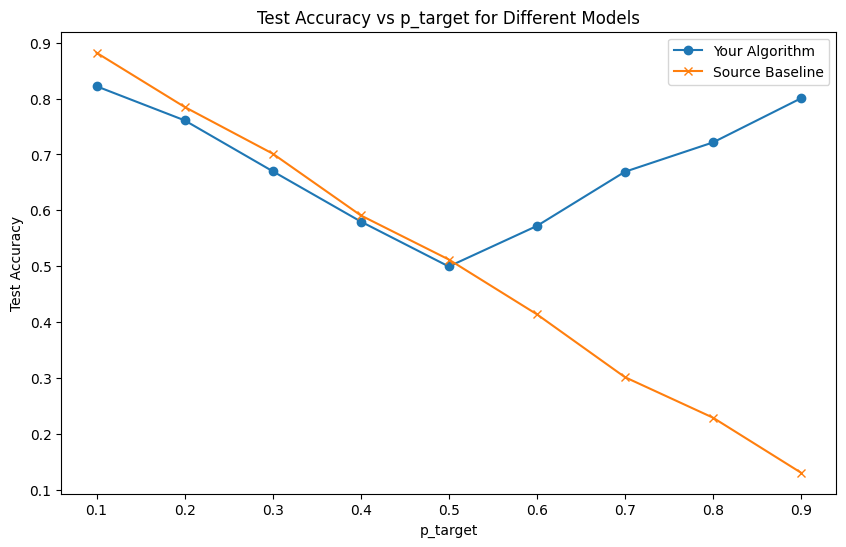

In [308]:
# Plotting Test Accuracy
plt.figure(figsize=(10, 6))

# Plot your algorithm's accuracy
p_target_values_accuracy = [x[0] for x in accuracy_results]
accuracy_your_algorithm = [x[1] for x in accuracy_results]
plt.plot(p_target_values_accuracy, accuracy_your_algorithm, label="Your Algorithm", marker='o')

# Plot COVAR accuracy if available
if run_covar:
    p_target_values_covar_accuracy = [x[0] for x in accuracy_results_covar]
    accuracy_covar_results = [x[1] for x in accuracy_results_covar]
    plt.plot(p_target_values_covar_accuracy, accuracy_covar_results, label="COVAR", marker='s')

# Plot Label Shift accuracy if available
if run_label_shift:
    p_target_values_label_shift_accuracy = [x[0] for x in accuracy_results_label_shift]
    accuracy_label_shift_results = [x[1] for x in accuracy_results_label_shift]
    plt.plot(p_target_values_label_shift_accuracy, accuracy_label_shift_results, label="Label Shift", marker='^')

# Plot Source Baseline accuracy if available
if run_source_baseline:
    p_target_values_source_baseline_accuracy = [x[0] for x in accuracy_results_source_baseline]
    accuracy_source_baseline_results = [x[1] for x in accuracy_results_source_baseline]
    plt.plot(p_target_values_source_baseline_accuracy, accuracy_source_baseline_results, label="Source Baseline", marker='x')

# Add labels and title
plt.xlabel("p_target")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs p_target for Different Models")
plt.legend()

# Add grid for better readability
plt.grid(False)

# Show the plot
plt.show()


In [309]:
# Test data generation
for p_source_test in [0.1, 0.3, 0.5, 0.7, 0.9]:
    source_data, target_data = get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target=0.2, p_source=p_source_test, total=1000)
    _, _, _, _, Y_source = source_data
    _, _, _, _, Y_target = target_data
    
    source_class_1_proportion = np.mean([y.numpy() for y in Y_source])
    target_class_1_proportion = np.mean([y.numpy() for y in Y_target])
    
    print(f"p_source={p_source_test}, Source Class 1 Proportion: {source_class_1_proportion}")
    print(f"Target Class 1 Proportion: {target_class_1_proportion}")


p_source=0.1, Source Class 1 Proportion: 0.7860000133514404
Target Class 1 Proportion: 0.7250000238418579
p_source=0.3, Source Class 1 Proportion: 0.640999972820282
Target Class 1 Proportion: 0.7269999980926514
p_source=0.5, Source Class 1 Proportion: 0.5339999794960022
Target Class 1 Proportion: 0.7239999771118164
p_source=0.7, Source Class 1 Proportion: 0.33000001311302185
Target Class 1 Proportion: 0.7300000190734863
p_source=0.9, Source Class 1 Proportion: 0.20499999821186066
Target Class 1 Proportion: 0.7300000190734863
